# Applying logistic regression in python to discriminate between control and M. bovis infected animals using peripheral blood transcriptomics data from wiarda et al., 2020
### This analysis considers two approaches, one using logistic regression on variable genes that have been preprocessed using DESeq2 (vst normalised) and the other using latent variables inferred using PCA, ICA and NMF

In [1]:
## Load in all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from scipy import stats
from scipy.stats import kurtosis

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc, make_scorer,mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import warnings
import pickle
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

#font for plots
font = {'fontname':'Arial'}

In [ ]:
wiarda_data_raw = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/wiarda_vst_normalised_data.txt", sep = "\t").T

In [ ]:
wiarda_data_raw = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/wiarda_vst_normalised_data.txt", sep = "\t").T
wiarda_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/wiarda/wiarda_samples.csv", sep = "\t")
wiarda_labels = wiarda_labels[["Animal_Code", "Week", "Status"]].drop_duplicates()




np.array(wiarda_labels["Animal_Code"]) == np.array(wiarda_data_raw.index)
wiarda_labels["ID"] = wiarda_labels["Animal_Code"].str.extract(r"(\d{3})", expand=False)
wiarda_labels["Fold"] = wiarda_labels.groupby("ID").ngroup()
wiarda_labels.loc[wiarda_labels["Week"] == "W0", "Status"] = "Control" # Note the infected samples were sampled after infection (immediately) so may be worthwhile labelling them as Control (note this increased the CV accuracy from ~ 50 to 80)
# Check right order
np.array(wiarda_labels["Animal_Code"]) == np.array(wiarda_data_raw.index)

wiarda_labels_simple = wiarda_labels["Status"].to_numpy()
wiarda_folds = wiarda_labels["Fold"].to_numpy()


wiarda_labels_simple = np.where(wiarda_labels_simple == "Control", 0, np.where(wiarda_labels_simple == "Infected", 1, wiarda_labels_simple))
wiarda_labels_simple = wiarda_labels_simple.astype(int)

In [55]:
wiarda_labels

,Animal_Code,Week,Status,ID,Fold
0,864_Infected_W0,W0,Control,864,9
1,851_Infected_W0,W0,Control,851,3
2,865_Infected_W0,W0,Control,865,10
3,867_Infected_W0,W0,Control,867,11
4,858_Infected_W0,W0,Control,858,6
5,846_Control_W0,W0,Control,846,0
6,849_Control_W0,W0,Control,849,2
7,855_Control_W0,W0,Control,855,4
8,856_Control_W0,W0,Control,856,5
9,863_Control_W0,W0,Control,863,8


In [56]:
# Calcualte variances for VST normalised genes
variances = wiarda_data_raw.var(axis=0)
# take top 20% and filter
threshold = variances.quantile(.80) 
genes = variances > threshold
genes= genes.loc[genes==True].index
wiarda_data = wiarda_data_raw.filter(items = genes, axis=1)

In [57]:
wiarda_data.head()

,ENSBTAG00000054829,SMIM11,MRPS6,ITSN1,ABCG1,TFF2,TFF1,TMPRSS3,RSPH1,IFNGR2,...,ENSBTAG00000054086,ENSBTAG00000050585,ENSBTAG00000052194,ENSBTAG00000053934,SERPINB4,ENSBTAG00000050153,ENSBTAG00000050608,MAD2L1,ENSBTAG00000054081,ENSBTAG00000049569
864_Infected_W0,6.207804,8.702828,11.139440,8.469609,8.757711,9.105377,6.315622,6.374383,6.207804,11.441030,...,8.688024,6.481704,5.817545,8.553887,5.858207,6.498473,6.160338,7.123919,6.680564,5.514603
851_Infected_W0,5.745067,8.186451,10.361826,8.669788,8.689608,7.715515,5.616500,6.030547,6.062143,11.346942,...,6.669919,6.176186,6.227399,8.079167,5.745067,6.445426,6.092364,7.369686,7.164711,5.745067
865_Infected_W0,5.688487,8.065577,10.497505,8.535727,9.043225,7.471301,5.304047,6.125836,6.034544,11.294550,...,7.034206,5.304047,6.207092,7.686151,5.889012,5.747526,6.256980,7.335719,7.022763,6.096685
867_Infected_W0,5.822546,8.207177,10.715308,8.859780,9.012619,8.606056,5.304047,6.325185,5.957829,11.330907,...,7.589799,5.304047,5.957829,7.629523,5.304047,5.633029,6.653131,7.034160,7.839245,5.633029
858_Infected_W0,5.696797,8.080194,10.516251,8.877955,9.035688,7.650124,5.531267,6.082497,5.757093,11.242836,...,7.156953,6.475203,6.276960,7.124270,5.810055,6.413762,7.113180,7.008538,7.124270,5.696797


In [58]:
# Convert the custom folds array to a PredefinedSplit object
ps = PredefinedSplit(test_fold=wiarda_folds)

In [59]:

# Make a pipeline for logistic regression and set the paramaters
log_pipe = Pipeline(steps=[
('scaler', StandardScaler()), # see comment above (in markdown)
('classifier', LogisticRegression(max_iter=10000, solver='saga', tol=0.0001, random_state=42))]) # classifier

precision_scorer = make_scorer(precision_score, zero_division=1)  # had to modify zero_division as it was giving problems
f1_scorer = make_scorer(f1_score)
accuracy_scorer = make_scorer(accuracy_score)
recall_scorer = make_scorer(recall_score)

# Define scoring dictionary for GridSearchCV
scoring = {
    'accuracy': accuracy_scorer,
    #'f1': f1_scorer,
    #'precision': precision_scorer,
    #'recall': recall_scorer
}

# Create a parameter grid - we will search through all these combinations
param_grid = {
    'classifier__penalty': ["elasticnet"],
    'classifier__l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}
 
# Create GridSearchCV object
grid_search = GridSearchCV(log_pipe, param_grid, cv=ps, verbose=3, n_jobs=60, scoring=scoring, refit="accuracy")

In [60]:
wiarda_labels_simple

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [61]:
grid_search.fit(wiarda_data, wiarda_labels_simple)

Fitting 13 folds for each of 10 candidates, totalling 130 fits
[CV 12/13] END classifier__l1_ratio=0.4, classifier__penalty=elasticnet; accuracy: (test=0.333) total time=  13.2s
[CV 5/13] END classifier__l1_ratio=0.2, classifier__penalty=elasticnet; accuracy: (test=0.667) total time=  13.5s
[CV 5/13] END classifier__l1_ratio=0.4, classifier__penalty=elasticnet; accuracy: (test=0.667) total time=  13.7s
[CV 3/13] END classifier__l1_ratio=0.4, classifier__penalty=elasticnet; accuracy: (test=0.000) total time=  14.1s
[CV 11/13] END classifier__l1_ratio=0.1, classifier__penalty=elasticnet; accuracy: (test=0.667) total time=  14.3s
[CV 11/13] END classifier__l1_ratio=0.4, classifier__penalty=elasticnet; accuracy: (test=0.333) total time=  14.4s
[CV 10/13] END classifier__l1_ratio=0.3, classifier__penalty=elasticnet; accuracy: (test=1.000) total time=  14.4s
[CV 4/13] END classifier__l1_ratio=0.3, classifier__penalty=elasticnet; accuracy: (test=1.000) total time=  14.7s
[CV 6/13] END classif

GridSearchCV(cv=PredefinedSplit(test_fold=array([ 9,  3, 10, 11,  6,  0,  2,  4,  5,  8,  1,  7, 12,  0,  2,  1,  7,
       12,  9,  3, 10,  4, 11,  6,  5,  8,  1,  7, 12,  9,  3, 10, 11,  6,
        0,  2,  4,  5,  8])),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=60,
             param_grid={'classifier__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1],
                         'classifier__penalty': ['elasticnet']},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score)}, verbose=3)

In [62]:
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV average accuracy: {grid_search.best_score_:.3f}")
results_genes = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_accuracy"], columns = ["Average Accuracy"]),
           pd.DataFrame(grid_search.cv_results_["std_test_accuracy"], columns=["SD accuracy"])],axis=1)
results_genes.sort_values(by='Average Accuracy', inplace=True)

Best Parameters: {'classifier__l1_ratio': 0.1, 'classifier__penalty': 'elasticnet'}
Best CV average accuracy: 0.846


In [63]:
results_genes
results_models = pd.DataFrame(grid_search.cv_results_)
results_models.sort_values(by='rank_test_accuracy', inplace=True)
results_genes

,classifier__l1_ratio,classifier__penalty,Average Accuracy,SD accuracy
2,0.3,elasticnet,0.743590,0.324336
3,0.4,elasticnet,0.743590,0.324336
4,0.5,elasticnet,0.743590,0.324336
5,0.6,elasticnet,0.743590,0.324336
6,0.7,elasticnet,0.743590,0.324336
7,0.8,elasticnet,0.769231,0.303389
8,0.9,elasticnet,0.769231,0.303389
9,1.0,elasticnet,0.769231,0.303389
1,0.2,elasticnet,0.794872,0.307692
0,0.1,elasticnet,0.846154,0.280883


In [68]:
data_test = pd.DataFrame(zip(wiarda_data.columns, np.transpose(grid_search.best_estimator_.named_steps["classifier"].coef_)), columns=['features', 'coef'])#.sort_values(by='coef', inplace=True)
data_test.sort_values(by='coef', inplace = True)
data_test = data_test.loc[(data_test != 0).all(axis=1), :]
data_test

,features,coef
888,DIRAS3,[-0.05842370002683579]
3543,ENSBTAG00000048885,[-0.05254238789476099]
5484,ENSBTAG00000052325,[-0.05120259011795917]
2029,FGF1,[-0.05059383055309786]
2886,MS4A14,[-0.048294800587800446]
...,...,...
1891,HK3,[0.05488966822134522]
2293,ADCY3,[0.05818909888388803]
3109,ENSBTAG00000054718,[0.0636322316731776]
2819,MDK,[0.06398508405895612]


# PCA

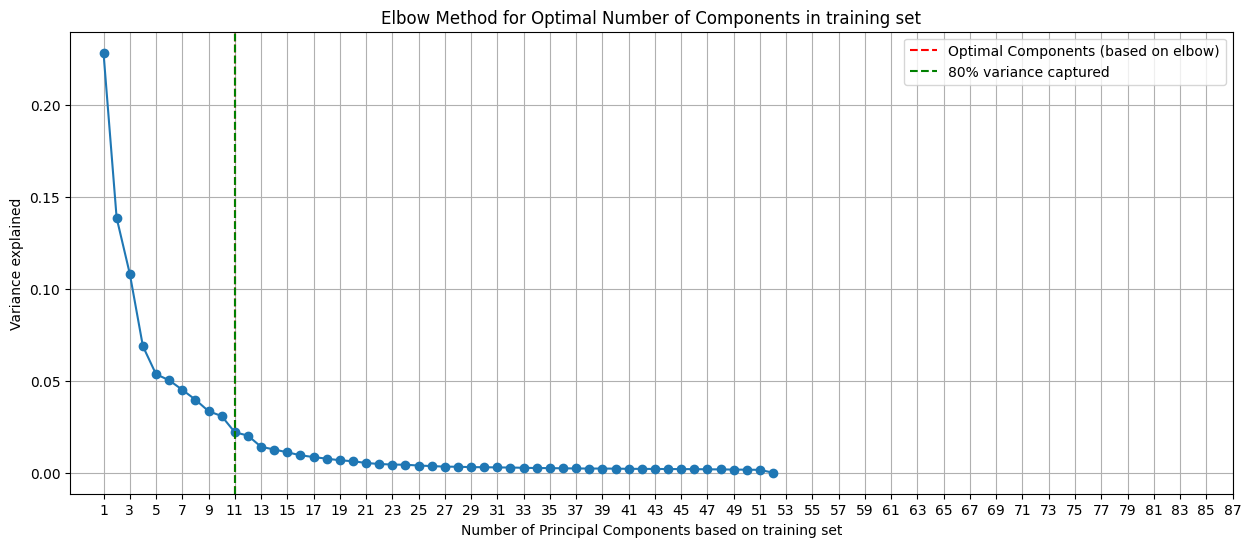

Variance captured by 11 PCs:0.82


In [ ]:
 
# Do not need to scale for PCA - not recommended in VST
pca = PCA(random_state=88, n_components=52)
pca.fit(kirsten_data)
explained_variance = pca.explained_variance_ratio_
# Plotting the elbow curve
plt.figure(figsize=(15, 6))
plt.plot(range(1, 52+1), explained_variance, marker='o')
plt.xlabel('Number of Principal Components based on training set')
plt.ylabel('Variance explained')
plt.title('Elbow Method for Optimal Number of Components in training set')
plt.grid()
plt.xticks(range(1, 87 + 1,2))
plt.axvline(x=11, color='r', linestyle='--', label='Optimal Components (based on elbow)')
plt.axvline(x=11, color='g', linestyle='--', label='80% variance captured')
plt.legend()
plt.show()
print(f'Variance captured by 11 PCs:{pca.explained_variance_ratio_[:11].sum():.2f}')

In [ ]:
# Set up the pipeline
PCA_Pipeline = Pipeline(steps=[('pca', PCA(random_state=42)),
('classifier', LogisticRegression(max_iter=10000, penalty="none", solver='saga', tol=0.0001, random_state=42))])

# Set up a grid for each PC
pca_param_grid = {'pca__n_components': list(range(1, 12))}

# Apply
LR_pca_search_model = GridSearchCV(PCA_Pipeline, pca_param_grid, cv=ps, scoring=scoring, refit="accuracy")

# Fit
LR_pca_search_model.fit(kirsten_data, kirsten_labels_simple.ravel())

GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 4, 5,
       6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0,
       1, 2, 3, 4, 5, 6, 7, 8])),
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='none',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)})